In [1]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

!pip install -q tf-nightly-2.0-preview

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

In [2]:
# upload data

# --- colab
# from google.colab import files
# uploaded = files.upload()
# ---

import os

def load_data():
    path = '/Users/jy/Desktop/MJU/4-1/DeepLearning/wine-reviews'
    fpath = os.path.join(path, 'winemag-data-130k-v2.csv')
    return pd.read_csv(fpath)

data = load_data()
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# --- colab

# load data

# import io
# data = pd.read_csv(io.BytesIO(uploaded['winemag-data-130k-v2.csv']))

# data.info()
# data.head()

# ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
# rating 분포

reviews = pd.DataFrame(data.groupby('points').size().rename('number of reviewers').reset_index())
reviews

,points,number of reviewers
0,80,397
1,81,692
2,82,1836
3,83,3025
4,84,6480
5,85,9530
6,86,12600
7,87,16933
8,88,17207
9,89,12226


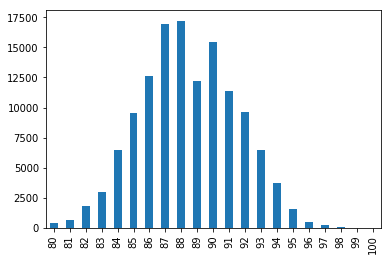

In [8]:
data['points'].value_counts().sort_index().plot.bar()

In [76]:
# remove duplication

print("data shape: ", data.shape)
print("Total number of examples: ", data.shape[0])
print("Number of examples with the same title and description: ", data[data.duplicated(['description','title'])].shape[0])

data=data.drop_duplicates(['description','title'])
data=data.reset_index(drop=True)

print("Total number of examples: ", data.shape[0])

data shape:  (129971, 14)
Total number of examples:  129971
Number of examples with the same title and description:  9983
Total number of examples:  119988


In [77]:
# Keeping only the neccessary columns
permanent = data[['description', 'points']]
permanent.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [78]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocessing_corpus(corpus):
    corpus = corpus.str.lower()
    corpus = corpus.str.replace(r'[^a-z0-9\s]', ' ', regex=True)
    return corpus.values.tolist()

def making_vocab(corpus, top_n_ratio=1.0):
    words = np.concatenate(np.core.defchararray.split(corpus)).tolist()

    stopWords = set(stopwords.words('english'))
    words = [word for word in words if word not in stopWords]

    counter = Counter(words)
    if top_n_ratio is not 1.0:
        counter = Counter(dict(counter.most_common(int(top_n_ratio*len(counter)))))
    unique_words = list(counter) + ['UNK']
    return unique_words

[nltk_data] Downloading package stopwords to /Users/jy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
corpus = preprocessing_corpus(permanent['description'])
print(corpus[0])
print(type(corpus))

vocab = making_vocab(corpus, top_n_ratio=0.8)
print(vocab[:10])

aromas include tropical fruit  broom  brimstone and dried herb  the palate isn t overly expressive  offering unripened apple  citrus and dried sage alongside brisk acidity 
<class 'list'>
['wine', 'flavors', 'fruit', 'aromas', 'palate', 'finish', 'acidity', 'tannins', 'drink', 'cherry']


In [80]:
def vocab_indexing(vocab):
    word2index = { word:(index + 1) for index, word in enumerate(vocab) }
    return word2index

word2index = vocab_indexing(vocab)

vocab_size = len(word2index)
print("{'wine': ", word2index['wine'], ", ...}")
print("vocab size: ", vocab_size)

{'wine':  1 , ...}
vocab size:  24771


In [81]:
def word_index_into_corpus(word2index, corpus):
    indexed_corpus = []
    for doc in corpus:
        indexed_corpus.append([word2index[word] if word in word2index else 0 for word in doc.split()])
    return indexed_corpus

indexed_corpus = word_index_into_corpus(word2index, corpus)
print(len(indexed_corpus))
print(type(indexed_corpus))
print(indexed_corpus[0])


119988
<class 'list'>
[4, 786, 159, 3, 1942, 3661, 0, 57, 72, 0, 5, 0, 0, 933, 839, 256, 13541, 28, 37, 0, 57, 360, 104, 308, 7]


In [82]:
# get max length
maxValue = 0
for idx, sentance in enumerate(indexed_corpus):
  if maxValue < len(indexed_corpus[idx]):
    maxValue = len(indexed_corpus[idx])
    
print(maxValue)

138


In [83]:
# get min length
minValue = 138
for idx, sentance in enumerate(indexed_corpus):
  if minValue > len(indexed_corpus[idx]):
    minValue = len(indexed_corpus[idx])
    
print(minValue)

3


In [84]:
# add padding
maxlen = 138

train_data = keras.preprocessing.sequence.pad_sequences(indexed_corpus,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=maxlen)

In [85]:
print(train_data.shape)
print(type(train_data))

(119988, 138)
<class 'numpy.ndarray'>


In [86]:
# train_data, train_labels
train_labels = []

for index, point in enumerate(permanent['points']):
    if point < 84:
        train_labels.append(0)
    elif point >= 84 and point < 88:
        train_labels.append(1)
    elif point >= 88 and point < 92:
        train_labels.append(2)
    elif point >= 92 and point < 96:
        train_labels.append(3)
    else:
        train_labels.append(4)

train_labels = np.array(train_labels)
print(train_labels)

[1 1 1 ... 2 2 2]


In [87]:
print(train_data)
print(len(train_data))

print(train_labels)
print(len(train_labels))
print(type(train_labels))

[[    4   786   159 ...     0     0     0]
 [    0     0    12 ...     0     0     0]
 [   77     0   844 ...     0     0     0]
 ...
 [   27 15592  1486 ...     0     0     0]
 [    0    19    69 ...     0     0     0]
 [  140    17     0 ...     0     0     0]]
119988
[1 1 1 ... 2 2 2]
119988
<class 'numpy.ndarray'>


In [47]:
embedding_dim = 16

model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxValue),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 138, 16)           396336    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 396,693
Trainable params: 396,693
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    x=train_data,
    y=train_labels,
    epochs=30,
    batch_size=512,
    validation_split=0.2,
    shuffle=True
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/30
95990/95990 [==============================] - 3s 31us/sample - loss: 1.3697 - accuracy: 0.4240 - val_loss: 1.2628 - val_accuracy: 0.4192
Epoch 2/30
95990/95990 [==============================] - 3s 28us/sample - loss: 1.1606 - accuracy: 0.4792 - val_loss: 1.1839 - val_accuracy: 0.5519
Epoch 3/30
95990/95990 [==============================] - 3s 29us/sample - loss: 1.0522 - accuracy: 0.5842 - val_loss: 1.0426 - val_accuracy: 0.5711
Epoch 4/30
95990/95990 [==============================] - 3s 28us/sample - loss: 0.9282 - accuracy: 0.6124 - val_loss: 0.9424 - val_accuracy: 0.6090
Epoch 5/30
95990/95990 [==============================] - 3s 28us/sample - loss: 0.8526 - accuracy: 0.6430 - val_loss: 0.8837 - val_accuracy: 0.6329
Epoch 6/30
95990/95990 [==============================] - 3s 29us/sample - loss: 0.8034 - accuracy: 0.6607 - val_loss: 0.8439 - val_accuracy: 0.6412
Epoch 7/30
95990/95990 [==============================] 

In [0]:
model2 = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxValue),
  layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
  layers.Dense(5, activation='softmax')
])

model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 138, 16)           396336    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 438,453
Trainable params: 438,453
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 231s 2ms/sample - loss: 1.1751 - accuracy: 0.4622 - val_loss: 0.9743 - val_accuracy: 0.5549
Epoch 2/10
95990/95990 [==============================] - 226s 2ms/sample - loss: 0.8408 - accuracy: 0.6279 - val_loss: 0.7971 - val_accuracy: 0.6380
Epoch 3/10
95990/95990 [==============================] - 224s 2ms/sample - loss: 0.7473 - accuracy: 0.6725 - val_loss: 0.7507 - val_accuracy: 0.6697
Epoch 4/10
95990/95990 [==============================] - 225s 2ms/sample - loss: 0.6996 - accuracy: 0.6961 - val_loss: 0.7493 - val_accuracy: 0.6703
Epoch 5/10
95990/95990 [==============================] - 223s 2ms/sample - loss: 0.6699 - accuracy: 0.7087 - val_loss: 0.7456 - val_accuracy: 0.6723
Epoch 6/10
95990/95990 [==============================] - 222s 2ms/sample - loss: 0.6564 - accuracy: 0.7186 - val_loss: 0.7371 - val_accuracy: 0.6765
Epoch 7/10
95990/95990 [==========================

In [19]:
# upload data & load the whole embedding into memory

glove_path = '/Users/jy/Desktop/MJU/4-1/DeepLearning/glove.6B'
glove_fpath = os.path.join(glove_path, 'glove.6B.100d.txt')
f = open(glove_fpath)

embeddings_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
# create a weight matrix for words in training docs
# vocab_size: 24771

not_in_glove = 0

embedding_matrix = np.zeros((vocab_size, 100))
for index, word in enumerate(vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        not_in_glove += 1

print(embedding_matrix)
print(embedding_matrix.shape)
print('not_in_glove: ', not_in_glove)

[[-0.47652999  0.42094001  0.17423999 ... -0.54451001  0.80343002
   0.50082999]
 [-0.52666998  0.64282     0.26199999 ... -0.71044999  0.33175999
   0.85721999]
 [-0.86568999  0.48032999 -0.39666    ... -0.69826001  1.19219995
   0.41204   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(24771, 100)
not_in_glove:  4030


In [59]:
from keras.initializers import Constant

embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue
)

model3 = keras.Sequential([
    embedding_layer,
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(5, activation='softmax')
])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 645       
Total params: 2,562,225
Trainable params: 2,562,225
Non-trainable params: 0
_________________________________________________________________


In [60]:
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history3 = model3.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 276s 3ms/sample - loss: 1.0912 - acc: 0.4994 - val_loss: 0.9218 - val_acc: 0.5903
Epoch 2/10
95990/95990 [==============================] - 260s 3ms/sample - loss: 0.8309 - acc: 0.6307 - val_loss: 0.7832 - val_acc: 0.6543
Epoch 3/10
95990/95990 [==============================] - 265s 3ms/sample - loss: 0.7405 - acc: 0.6753 - val_loss: 0.7433 - val_acc: 0.6714
Epoch 4/10
95990/95990 [==============================] - 275s 3ms/sample - loss: 0.6966 - acc: 0.6963 - val_loss: 0.7280 - val_acc: 0.6823
Epoch 5/10
95990/95990 [==============================] - 279s 3ms/sample - loss: 0.6636 - acc: 0.7120 - val_loss: 0.7196 - val_acc: 0.6838
Epoch 6/10
95990/95990 [==============================] - 263s 3ms/sample - loss: 0.6382 - acc: 0.7256 - val_loss: 0.7219 - val_acc: 0.6851
Epoch 7/10
95990/95990 [==============================] - 262s 3ms/sample - loss: 0.6161 - acc: 0.7356 - val_l

KeyboardInterrupt: 

In [78]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue
)

model4 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, padding='same', activation='relu'),
    layers.Dense(32, activation='tanh'),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model4.summary()
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 138, 64)           32064     
_________________________________________________________________
dense_34 (Dense)             (None, 138, 32)           2080      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               49664     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 325       
Total params: 2,569,489
Trainable params: 2,569,489
Non-trainable params: 0
_________________________________________________________________


In [79]:
history4 = model4.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 247s 3ms/sample - loss: 1.1517 - acc: 0.4621 - val_loss: 0.9698 - val_acc: 0.5752
Epoch 2/10
95990/95990 [==============================] - 245s 3ms/sample - loss: 0.8532 - acc: 0.6221 - val_loss: 0.7887 - val_acc: 0.6483
Epoch 3/10
95990/95990 [==============================] - 265s 3ms/sample - loss: 0.7607 - acc: 0.6642 - val_loss: 0.7762 - val_acc: 0.6615
Epoch 4/10
95990/95990 [==============================] - 244s 3ms/sample - loss: 0.7165 - acc: 0.6862 - val_loss: 0.7487 - val_acc: 0.6761
Epoch 5/10
95990/95990 [==============================] - 258s 3ms/sample - loss: 0.6913 - acc: 0.7006 - val_loss: 0.7370 - val_acc: 0.6784
Epoch 6/10
 8704/95990 [=>............................] - ETA: 3:45 - loss: 0.6613 - acc: 0.7160

KeyboardInterrupt: 

In [100]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue
)

model5 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    layers.Dense(32, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model5.summary()
model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 138, 64)           32064     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 69, 64)            0         
_________________________________________________________________
dense_70 (Dense)             (None, 69, 32)            2080      
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 65, 16)            2576      
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               41472     
_________________________________________________________________
dense_71 (Dense)             (None, 64)                8256      
__________

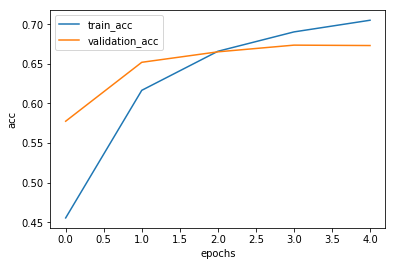

In [92]:
import matplotlib.pyplot as plt

plt.plot(history5.history['acc'], label='train_acc')
plt.plot(history5.history["val_acc"], label='validation_acc')

plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [101]:
history5 = model5.fit(
    x=train_data,
    y=train_labels,
    epochs=200,
    batch_size=512,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/200
95990/95990 [==============================] - 149s 2ms/sample - loss: 1.1030 - acc: 0.4916 - val_loss: 0.9020 - val_acc: 0.5963
Epoch 2/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.8231 - acc: 0.6333 - val_loss: 0.7877 - val_acc: 0.6544
Epoch 3/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.7493 - acc: 0.6688 - val_loss: 0.7727 - val_acc: 0.6603
Epoch 4/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.7029 - acc: 0.6925 - val_loss: 0.7541 - val_acc: 0.6681
Epoch 5/200
95990/95990 [==============================] - 142s 1ms/sample - loss: 0.6741 - acc: 0.7066 - val_loss: 0.7479 - val_acc: 0.6724
Epoch 6/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.6464 - acc: 0.7218 - val_loss: 0.8433 - val_acc: 0.6408
Epoch 7/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.6285 - acc: 0.7324 

95990/95990 [==============================] - 141s 1ms/sample - loss: 0.0044 - acc: 0.9986 - val_loss: 3.7656 - val_acc: 0.6076
Epoch 116/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.0044 - acc: 0.9987 - val_loss: 3.8051 - val_acc: 0.6058
Epoch 117/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.0082 - acc: 0.9973 - val_loss: 3.7619 - val_acc: 0.6063
Epoch 118/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.0187 - acc: 0.9936 - val_loss: 3.4473 - val_acc: 0.6075
Epoch 119/200
95990/95990 [==============================] - 142s 1ms/sample - loss: 0.0236 - acc: 0.9922 - val_loss: 3.3142 - val_acc: 0.6061
Epoch 120/200
95990/95990 [==============================] - 141s 1ms/sample - loss: 0.0117 - acc: 0.9962 - val_loss: 3.6251 - val_acc: 0.6010
Epoch 121/200
95990/95990 [==============================] - 142s 1ms/sample - loss: 0.0103 - acc: 0.9967 - val_loss: 3.6032 - val_acc: 0.6101
Epoch 122/200

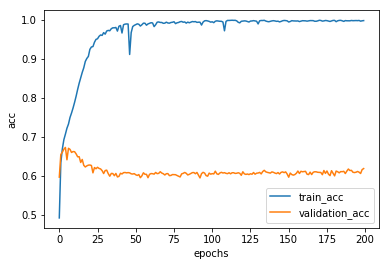

In [102]:
import matplotlib.pyplot as plt

plt.plot(history5.history['acc'], label='train_acc')
plt.plot(history5.history["val_acc"], label='validation_acc')

plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [117]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model6 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.1),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(32, dropout=0.21, recurrent_dropout=0.1)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(5, activation='softmax')
])
model6.summary()
model6.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 134, 64)           32064     
_________________________________________________________________
average_pooling1d_14 (Averag (None, 67, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 67, 64)            0         
_________________________________________________________________
dense_109 (Dense)            (None, 67, 40)            2600      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 63, 16)            3216      
_________________________________________________________________
average_pooling1d_15 (Averag (None, 31, 16)            0         
__________

In [118]:
history6 = model6.fit(
    x=train_data,
    y=train_labels,
    epochs=20,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/20
95990/95990 [==============================] - 78s 812us/sample - loss: 1.1281 - acc: 0.4778 - val_loss: 1.0656 - val_acc: 0.5288
Epoch 2/20
95990/95990 [==============================] - 74s 775us/sample - loss: 1.0202 - acc: 0.5348 - val_loss: 1.0284 - val_acc: 0.5411
Epoch 3/20
95990/95990 [==============================] - 79s 825us/sample - loss: 0.9712 - acc: 0.5598 - val_loss: 0.9585 - val_acc: 0.5722
Epoch 4/20
95990/95990 [==============================] - 81s 844us/sample - loss: 0.9222 - acc: 0.5854 - val_loss: 0.9172 - val_acc: 0.5899
Epoch 5/20
95990/95990 [==============================] - 85s 885us/sample - loss: 0.8866 - acc: 0.6035 - val_loss: 0.9023 - val_acc: 0.5966
Epoch 6/20
95990/95990 [==============================] - 83s 868us/sample - loss: 0.8642 - acc: 0.6136 - val_loss: 0.8909 - val_acc: 0.6050
Epoch 7/20
95990/95990 [==============================] - 83s 862us/sample - loss: 0.8412 - acc: 0.6245 

In [119]:
history6 = model6.fit(
    x=train_data,
    y=train_labels,
    epochs=30,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/30
95990/95990 [==============================] - 75s 781us/sample - loss: 0.7221 - acc: 0.6807 - val_loss: 0.8479 - val_acc: 0.6340
Epoch 2/30
95990/95990 [==============================] - 75s 784us/sample - loss: 0.7158 - acc: 0.6835 - val_loss: 0.8414 - val_acc: 0.6331
Epoch 3/30
95990/95990 [==============================] - 76s 787us/sample - loss: 0.7109 - acc: 0.6870 - val_loss: 0.8674 - val_acc: 0.6189
Epoch 4/30
95990/95990 [==============================] - 76s 789us/sample - loss: 0.7093 - acc: 0.6876 - val_loss: 0.8614 - val_acc: 0.6271
Epoch 5/30
95990/95990 [==============================] - 76s 795us/sample - loss: 0.7060 - acc: 0.6901 - val_loss: 0.8550 - val_acc: 0.6276
Epoch 6/30
95990/95990 [==============================] - 77s 797us/sample - loss: 0.7040 - acc: 0.6913 - val_loss: 0.8554 - val_acc: 0.6305
Epoch 7/30
95990/95990 [==============================] - 76s 794us/sample - loss: 0.7013 - acc: 0.6920 

In [21]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model7 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.1),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(32, dropout=0.21, recurrent_dropout=0.1)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(3, activation='softmax')
])
model7.summary()
model7.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 138, 100)          2477100   
_________________________________________________________________
conv1d (Conv1D)              (None, 134, 64)           32064     
_________________________________________________________________
average_pooling1d (AveragePo (None, 67, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 67, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 67, 40)            2600      
_________________________________________________________________
conv1d_1 (Conv1D)    

In [22]:
history7 = model7.fit(
    x=train_data,
    y=train_labels,
    epochs=25,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/25
95990/95990 [==============================] - 77s 798us/sample - loss: 0.9138 - acc: 0.5428 - val_loss: 0.8684 - val_acc: 0.5790
Epoch 2/25
95990/95990 [==============================] - 74s 770us/sample - loss: 0.8353 - acc: 0.5969 - val_loss: 0.7723 - val_acc: 0.6332
Epoch 3/25
95990/95990 [==============================] - 74s 770us/sample - loss: 0.7820 - acc: 0.6259 - val_loss: 0.7408 - val_acc: 0.6508
Epoch 4/25
95990/95990 [==============================] - 74s 766us/sample - loss: 0.7510 - acc: 0.6438 - val_loss: 0.7145 - val_acc: 0.6648
Epoch 5/25
95990/95990 [==============================] - 74s 769us/sample - loss: 0.7298 - acc: 0.6552 - val_loss: 0.7095 - val_acc: 0.6656
Epoch 6/25
95990/95990 [==============================] - 74s 776us/sample - loss: 0.7135 - acc: 0.6653 - val_loss: 0.7319 - val_acc: 0.6547
Epoch 7/25
95990/95990 [==============================] - 92s 961us/sample - loss: 0.6961 - acc: 0.6747 

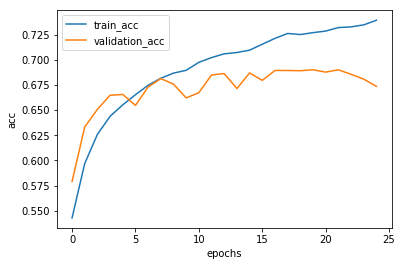

In [24]:
import matplotlib.pyplot as plt

plt.plot(history7.history['acc'], label='train_acc')
plt.plot(history7.history["val_acc"], label='validation_acc')

plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [25]:
history7 = model7.fit(
    x=train_data,
    y=train_labels,
    epochs=25,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/25
95990/95990 [==============================] - 77s 805us/sample - loss: 0.5742 - acc: 0.7410 - val_loss: 0.6923 - val_acc: 0.6876
Epoch 2/25
95990/95990 [==============================] - 78s 810us/sample - loss: 0.5687 - acc: 0.7431 - val_loss: 0.6846 - val_acc: 0.6838
Epoch 3/25
95990/95990 [==============================] - 77s 804us/sample - loss: 0.5657 - acc: 0.7472 - val_loss: 0.6913 - val_acc: 0.6848
Epoch 4/25
95990/95990 [==============================] - 77s 806us/sample - loss: 0.5647 - acc: 0.7472 - val_loss: 0.7458 - val_acc: 0.6644
Epoch 5/25
95990/95990 [==============================] - 82s 849us/sample - loss: 0.5639 - acc: 0.7465 - val_loss: 0.6976 - val_acc: 0.6843
Epoch 6/25
95990/95990 [==============================] - 85s 884us/sample - loss: 0.5573 - acc: 0.7507 - val_loss: 0.6929 - val_acc: 0.6851
Epoch 7/25
95990/95990 [==============================] - 83s 867us/sample - loss: 0.5564 - acc: 0.7512 

KeyboardInterrupt: 

In [42]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model8 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.1),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(32, dropout=0.21, recurrent_dropout=0.1)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])
model8.summary()
model8.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 134, 64)           32064     
_________________________________________________________________
average_pooling1d_4 (Average (None, 67, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 67, 64)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 67, 40)            2600      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 63, 16)            3216      
_________________________________________________________________
average_pooling1d_5 (Average (None, 31, 16)            0         
__________

In [43]:
history8 = model8.fit(
    x=train_data,
    y=train_labels,
    epochs=25,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
95990/95990 [==============================] - 81s 849us/sample - loss: 0.5816 - acc: 0.6909 - val_loss: 0.5237 - val_acc: 0.7399
Epoch 2/25
95990/95990 [==============================] - 80s 832us/sample - loss: 0.5245 - acc: 0.7362 - val_loss: 0.4725 - val_acc: 0.7756
Epoch 3/25
95990/95990 [==============================] - 81s 841us/sample - loss: 0.4966 - acc: 0.7570 - val_loss: 0.4713 - val_acc: 0.7730
Epoch 4/25
95990/95990 [==============================] - 78s 808us/sample - loss: 0.4653 - acc: 0.7790 - val_loss: 0.4402 - val_acc: 0.7904
Epoch 5/25
95990/95990 [==============================] - 76s 792us/sample - loss: 0.4520 - acc: 0.7860 - val_loss: 0.4382 - val_acc: 0.7919
Epoch 6/25
95990/95990 [==============================] - 76s 796us/sample - loss: 0.4344 - acc: 0.7973 - val_loss: 0.4476 - val_acc: 0.7918
Epoch 7/25
95990/95990 [==============================] 

In [44]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model9 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.15),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.LSTM(32, dropout=0.21, recurrent_dropout=0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model9.summary()
model9.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 134, 64)           32064     
_________________________________________________________________
average_pooling1d_6 (Average (None, 67, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 67, 64)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 67, 40)            2600      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 63, 16)            3216      
_________________________________________________________________
average_pooling1d_7 (Average (None, 31, 16)            0         
__________

In [45]:
history9 = model9.fit(
    x=train_data,
    y=train_labels,
    epochs=20,
    batch_size=256,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/20
95990/95990 [==============================] - 85s 885us/sample - loss: 0.6498 - acc: 0.5992 - val_loss: 0.5675 - val_acc: 0.7067
Epoch 2/20
95990/95990 [==============================] - 86s 901us/sample - loss: 0.5653 - acc: 0.7082 - val_loss: 0.5382 - val_acc: 0.7294
Epoch 3/20
95990/95990 [==============================] - 73s 756us/sample - loss: 0.5166 - acc: 0.7444 - val_loss: 0.4761 - val_acc: 0.7710
Epoch 4/20
95990/95990 [==============================] - 74s 768us/sample - loss: 0.4867 - acc: 0.7629 - val_loss: 0.4855 - val_acc: 0.7701
Epoch 5/20
95990/95990 [==============================] - 71s 735us/sample - loss: 0.4654 - acc: 0.7766 - val_loss: 0.4396 - val_acc: 0.7932
Epoch 6/20
95990/95990 [==============================] - 72s 746us/sample - loss: 0.4500 - acc: 0.7864 - val_loss: 0.4356 - val_acc: 0.7935
Epoch 7/20
95990/95990 [==============================] - 73s 758us/sample - loss: 0.4407 - acc: 0.7928 

KeyboardInterrupt: 

In [66]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model11 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.LSTM(150, dropout=0.2, recurrent_dropout=0.1, return_sequences=True),
    layers.AveragePooling1D(2),
    layers.Dropout(0.1),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
optimizer = optimizers.Adam(lr=0.0001, decay=0.0001);

model11.summary()
model11.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 134, 64)           32064     
_________________________________________________________________
lstm_24 (LSTM)               (None, 134, 150)          129000    
_________________________________________________________________
average_pooling1d_18 (Averag (None, 67, 150)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 67, 150)           0         
_________________________________________________________________
dense_37 (Dense)             (None, 67, 40)            6040      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 63, 16)            3216      
__________

In [67]:
history11 = model11.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 587s 6ms/sample - loss: 0.6163 - acc: 0.6517 - val_loss: 0.5650 - val_acc: 0.7041
Epoch 2/10
95990/95990 [==============================] - 579s 6ms/sample - loss: 0.5632 - acc: 0.7110 - val_loss: 0.5339 - val_acc: 0.7320
Epoch 3/10
95990/95990 [==============================] - 576s 6ms/sample - loss: 0.5469 - acc: 0.7227 - val_loss: 0.5156 - val_acc: 0.7461
Epoch 4/10
95990/95990 [==============================] - 578s 6ms/sample - loss: 0.5333 - acc: 0.7330 - val_loss: 0.5077 - val_acc: 0.7518
Epoch 5/10
95990/95990 [==============================] - 580s 6ms/sample - loss: 0.5245 - acc: 0.7392 - val_loss: 0.4936 - val_acc: 0.7590
Epoch 6/10
95990/95990 [==============================] - 578s 6ms/sample - loss: 0.5143 - acc: 0.7454 - val_loss: 0.4902 - val_acc: 0.7631
Epoch 7/10
95990/95990 [==============================] - 588s 6ms/sample - loss: 0.5057 - acc: 0.7513 - val_l

In [68]:
history11 = model11.fit(
    x=train_data,
    y=train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/20
95990/95990 [==============================] - 582s 6ms/sample - loss: 0.4812 - acc: 0.7681 - val_loss: 0.4545 - val_acc: 0.7839
Epoch 2/20
95990/95990 [==============================] - 579s 6ms/sample - loss: 0.4755 - acc: 0.7709 - val_loss: 0.4508 - val_acc: 0.7874
Epoch 3/20
95990/95990 [==============================] - 579s 6ms/sample - loss: 0.4725 - acc: 0.7740 - val_loss: 0.4511 - val_acc: 0.7859
Epoch 4/20
95990/95990 [==============================] - 581s 6ms/sample - loss: 0.4685 - acc: 0.7747 - val_loss: 0.4479 - val_acc: 0.7872
Epoch 5/20
95990/95990 [==============================] - 580s 6ms/sample - loss: 0.4648 - acc: 0.7778 - val_loss: 0.4460 - val_acc: 0.7885
Epoch 6/20
95990/95990 [==============================] - 581s 6ms/sample - loss: 0.4633 - acc: 0.7789 - val_loss: 0.4415 - val_acc: 0.7899
Epoch 7/20
95990/95990 [==============================] - 581s 6ms/sample - loss: 0.4603 - acc: 0.7813 - val_l

In [69]:
history11 = model11.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 580s 6ms/sample - loss: 0.4343 - acc: 0.7959 - val_loss: 0.4232 - val_acc: 0.8002
Epoch 2/10
95990/95990 [==============================] - 587s 6ms/sample - loss: 0.4338 - acc: 0.7954 - val_loss: 0.4222 - val_acc: 0.8020
Epoch 3/10
95990/95990 [==============================] - 597s 6ms/sample - loss: 0.4321 - acc: 0.7970 - val_loss: 0.4210 - val_acc: 0.8023
Epoch 4/10
95990/95990 [==============================] - 590s 6ms/sample - loss: 0.4309 - acc: 0.7968 - val_loss: 0.4261 - val_acc: 0.7984
Epoch 5/10
95990/95990 [==============================] - 629s 7ms/sample - loss: 0.4300 - acc: 0.7987 - val_loss: 0.4202 - val_acc: 0.8037
Epoch 6/10
95990/95990 [==============================] - 634s 7ms/sample - loss: 0.4279 - acc: 0.7999 - val_loss: 0.4196 - val_acc: 0.8042
Epoch 7/10
95990/95990 [==============================] - 628s 7ms/sample - loss: 0.4287 - acc: 0.7989 - val_l

In [71]:
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'final_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

cb_checkpoint = callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

history11 = model11.fit(
    x=train_data,
    y=train_labels,
    epochs=60,
    batch_size=64,
    validation_split=0.2,
    callbacks=[cb_checkpoint]
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.4236 - acc: 0.8021
Epoch 00001: val_loss improved from inf to 0.41773, saving model to /Users/jy/Desktop/MJU/4-1/DeepLearning/models/final_model.h5
95990/95990 [==============================] - 670s 7ms/sample - loss: 0.4236 - acc: 0.8021 - val_loss: 0.4177 - val_acc: 0.8040
Epoch 2/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.4240 - acc: 0.8015
Epoch 00002: val_loss improved from 0.41773 to 0.41750, saving model to /Users/jy/Desktop/MJU/4-1/DeepLearning/models/final_model.h5
95990/95990 [==============================] - 638s 7ms/sample - loss: 0.4241 - acc: 0.8014 - val_loss: 0.4175 - val_acc: 0.8044
Epoch 3/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.4221 - acc: 0.8024
Epoch 00003: val_loss improved from 0.41750 to 0.41697, saving model to /Users/jy/Desktop/MJU/4-1/DeepLearning/models/final_model.h5
95990/95990 

95936/95990 [============================>.] - ETA: 0s - loss: 0.3967 - acc: 0.8161
Epoch 00053: val_loss did not improve from 0.40899
95990/95990 [==============================] - 583s 6ms/sample - loss: 0.3966 - acc: 0.8162 - val_loss: 0.4091 - val_acc: 0.8098
Epoch 54/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.3963 - acc: 0.8168
Epoch 00054: val_loss improved from 0.40899 to 0.40865, saving model to /Users/jy/Desktop/MJU/4-1/DeepLearning/models/final_model.h5
95990/95990 [==============================] - 584s 6ms/sample - loss: 0.3964 - acc: 0.8168 - val_loss: 0.4087 - val_acc: 0.8097
Epoch 55/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.3955 - acc: 0.8168
Epoch 00055: val_loss did not improve from 0.40865
95990/95990 [==============================] - 584s 6ms/sample - loss: 0.3954 - acc: 0.8168 - val_loss: 0.4091 - val_acc: 0.8094
Epoch 56/60
95936/95990 [============================>.] - ETA: 0s - loss: 0.3953 - acc: 0.8179
Epoch 

In [72]:
history11 = model11.fit(
    x=train_data,
    y=train_labels,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[cb_checkpoint]
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/20
95936/95990 [============================>.] - ETA: 0s - loss: 0.3943 - acc: 0.8180
Epoch 00001: val_loss did not improve from 0.40795
95990/95990 [==============================] - 585s 6ms/sample - loss: 0.3943 - acc: 0.8179 - val_loss: 0.4094 - val_acc: 0.8097
Epoch 2/20
95936/95990 [============================>.] - ETA: 0s - loss: 0.3933 - acc: 0.8181
Epoch 00002: val_loss did not improve from 0.40795
95990/95990 [==============================] - 583s 6ms/sample - loss: 0.3933 - acc: 0.8181 - val_loss: 0.4084 - val_acc: 0.8100
Epoch 3/20
95936/95990 [============================>.] - ETA: 0s - loss: 0.3940 - acc: 0.8189
Epoch 00003: val_loss did not improve from 0.40795
95990/95990 [==============================] - 584s 6ms/sample - loss: 0.3940 - acc: 0.8188 - val_loss: 0.4081 - val_acc: 0.8101
Epoch 4/20
95936/95990 [============================>.] - ETA: 0s - loss: 0.3924 - acc: 0.8183
Epoch 00004: val_loss did not 

KeyboardInterrupt: 

In [64]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model12 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.1),
    layers.Dense(40, activation='tanh'),
    layers.Conv1D(16, 5, activation='relu'),
    layers.AveragePooling1D(2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(128, dropout=0.21, recurrent_dropout=0.1)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])
model12.summary()
model12.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 134, 64)           32064     
_________________________________________________________________
average_pooling1d_16 (Averag (None, 67, 64)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 67, 64)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 67, 40)            2600      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 63, 16)            3216      
_________________________________________________________________
average_pooling1d_17 (Averag (None, 31, 16)            0         
__________

In [65]:
history12 = model12.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95990/95990 [==============================] - 193s 2ms/sample - loss: 0.5674 - acc: 0.7035 - val_loss: 0.5128 - val_acc: 0.7491
Epoch 2/10
95990/95990 [==============================] - 184s 2ms/sample - loss: 0.4994 - acc: 0.7566 - val_loss: 0.4556 - val_acc: 0.7870
Epoch 3/10
95990/95990 [==============================] - 184s 2ms/sample - loss: 0.4682 - acc: 0.7753 - val_loss: 0.4406 - val_acc: 0.7926
Epoch 4/10
95990/95990 [==============================] - 182s 2ms/sample - loss: 0.4478 - acc: 0.7884 - val_loss: 0.4317 - val_acc: 0.7968
Epoch 5/10
95990/95990 [==============================] - 184s 2ms/sample - loss: 0.4337 - acc: 0.7969 - val_loss: 0.4246 - val_acc: 0.8011
Epoch 6/10
95990/95990 [==============================] - 183s 2ms/sample - loss: 0.4203 - acc: 0.8046 - val_loss: 0.4403 - val_acc: 0.7948
Epoch 7/10
95990/95990 [==============================] - 184s 2ms/sample - loss: 0.4083 - acc: 0.8108 - val_l

In [93]:
embedding_layer = layers.Embedding(
    vocab_size,
    100,
    weights=[embedding_matrix],
    input_length=maxValue,
    trainable=False
)

model13 = keras.Sequential([
    embedding_layer,
    layers.Conv1D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Conv1D(16, 5, activation='relu'),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model13.summary()
model13.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 138, 100)          2477100   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 138, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 64)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 69, 32)            2080      
_________________________________________________________________
dropout_26 (Dropout)         (None, 69, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 65, 16)            2576      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               41472     
__________

In [94]:
save_dir = os.path.join(os.getcwd(), 'models2')
model_name = 'final_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

cb_checkpoint = callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

history12 = model12.fit(
    x=train_data,
    y=train_labels,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[cb_checkpoint]
)

Train on 95990 samples, validate on 23998 samples
Epoch 1/10
95984/95990 [============================>.] - ETA: 0s - loss: -11.6538 - acc: 0.3572
Epoch 00001: val_loss improved from inf to -11.96509, saving model to /Users/jy/Desktop/MJU/4-1/DeepLearning/models2/final_model.h5
95990/95990 [==============================] - 437s 5ms/sample - loss: -11.6541 - acc: 0.3572 - val_loss: -11.9651 - val_acc: 0.3255
Epoch 2/10
95984/95990 [============================>.] - ETA: 0s - loss: -11.6538 - acc: 0.3572
Epoch 00002: val_loss did not improve from -11.96509
95990/95990 [==============================] - 439s 5ms/sample - loss: -11.6541 - acc: 0.3572 - val_loss: -11.9651 - val_acc: 0.3255
Epoch 3/10
95984/95990 [============================>.] - ETA: 0s - loss: -11.6543 - acc: 0.3572
Epoch 00003: val_loss did not improve from -11.96509
95990/95990 [==============================] - 441s 5ms/sample - loss: -11.6541 - acc: 0.3572 - val_loss: -11.9651 - val_acc: 0.3255
Epoch 4/10
16352/95990

KeyboardInterrupt: 